In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline, DDPMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## Learning is very difficult, but cats save the day.

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-cat-256")
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\Wenbzhan\.cache\huggingface\hub\models--google--ddpm-cat-256\snapshots\82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Wenbzhan\.cache\huggingface\hub\models--google--ddpm-cat-256\snapshots\82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-cat-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

## Lets generate 4 cat images

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\diffusers\models\attention_processor.py:2383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 1000/1000 [00:53<00:00, 18.76it/s]


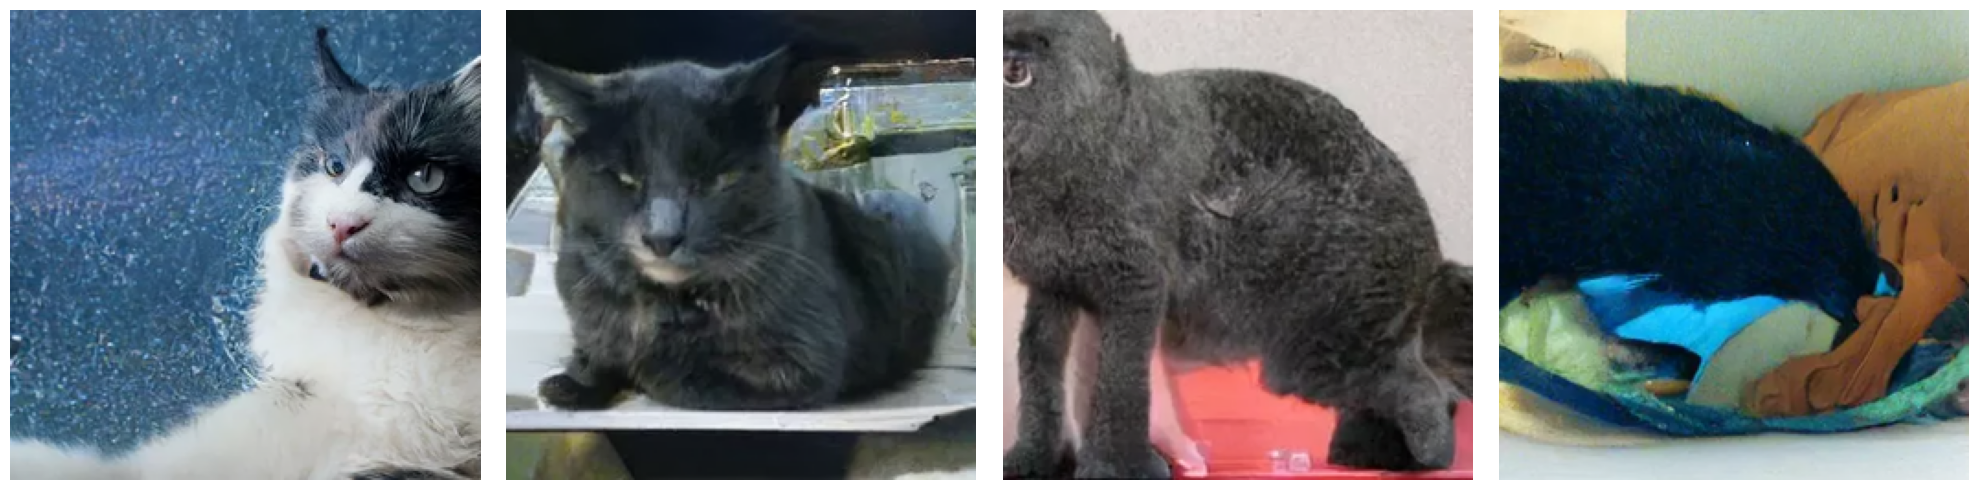

In [4]:
cat_image_list = []
for i in range(0, 4):
    images = image_pipe().images
    cat_image_list.append(images[0])

n_images = len(cat_image_list)

# Create a figure with 1 row and `n_images` columns
fig, axs = plt.subplots(1, n_images, figsize=(20, 5))  # Width 20, Height 5

# Loop through the images and plot them in one row
for idx, image in enumerate(cat_image_list):
    axs[idx].imshow(image)  # Display the image
    axs[idx].axis('off')    # Remove axis for cleaner display

# Display the plots
plt.tight_layout()
plt.show()

1000 steps realy takes very long time. Let's try only use 400 steps.

100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


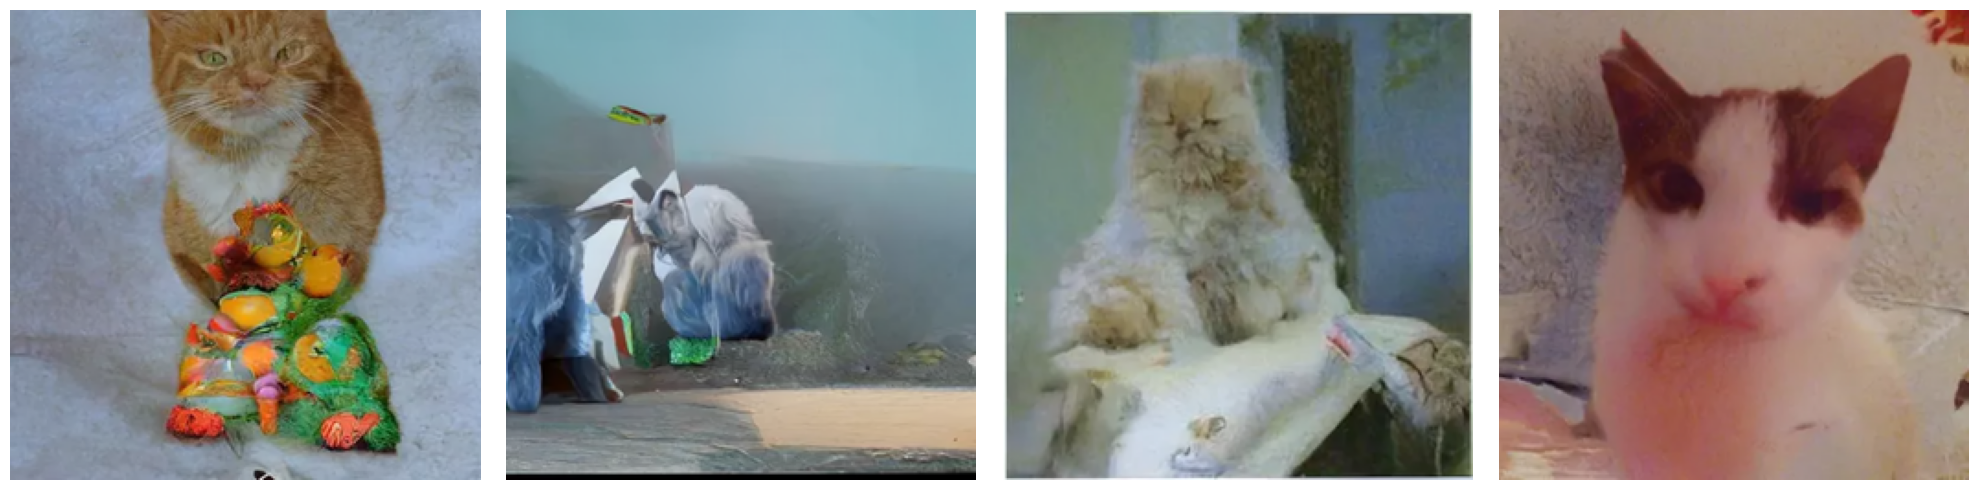

In [6]:
cat_image_list = []
for i in range(0,4):
    images = image_pipe(num_inference_steps=400).images
    cat_image_list.append(images[0])

n_images = len(cat_image_list)

# Create a figure with 1 row and `n_images` columns
fig, axs = plt.subplots(1, n_images, figsize=(20, 5))  # Width 20, Height 5

# Loop through the images and plot them in one row
for idx, image in enumerate(cat_image_list):
    axs[idx].imshow(image)  # Display the image
    axs[idx].axis('off')    # Remove axis for cleaner display

# Display the plots
plt.tight_layout()
plt.show()

## What does the model do during different inference steps

Replace the scheduler to see the model behavior

0it [00:00, ?it/s]

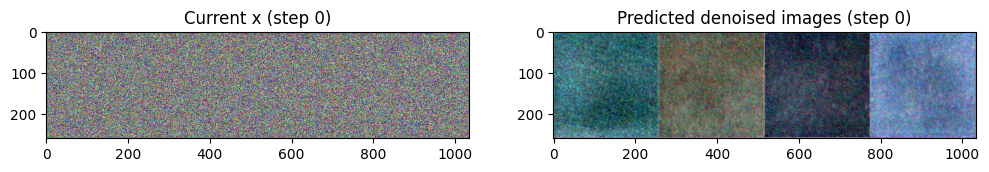

10it [00:01,  5.64it/s]

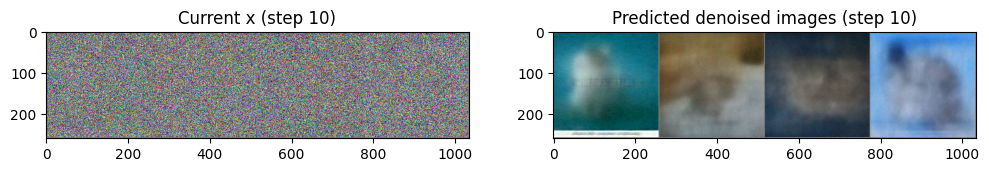

20it [00:03,  5.62it/s]

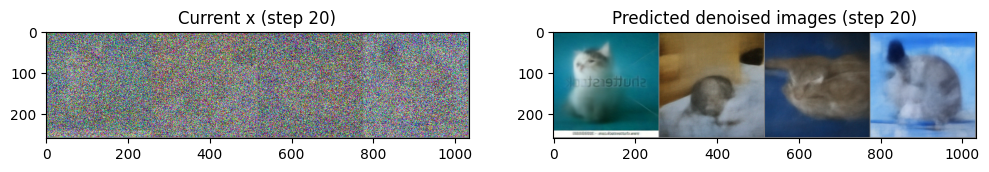

30it [00:05,  5.62it/s]

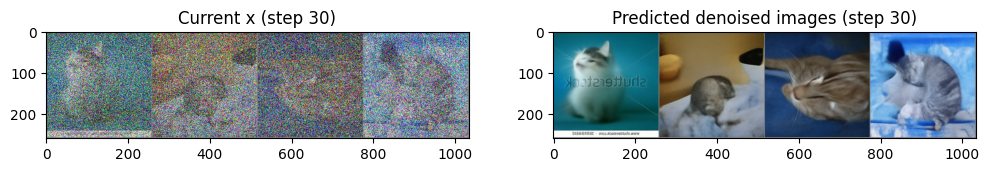

40it [00:07,  5.60it/s]

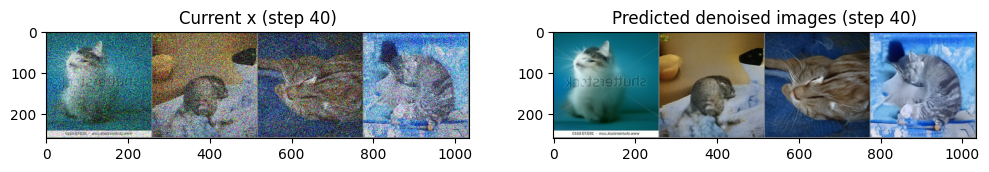

49it [00:09,  5.59it/s]

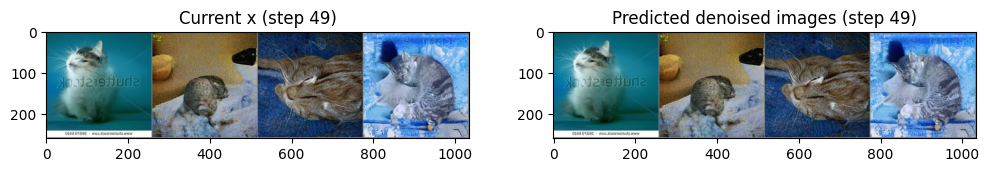

50it [00:09,  5.18it/s]


In [5]:
# Replace the default scheduler with DDIMScheduler (if you want DDIM behavior)
scheduler = DDIMScheduler.from_pretrained("google/ddpm-cat-256")
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps=num_inference_steps)
image_pipe.scheduler = scheduler

# Random starting point (batch of 4 images, 3 channels, 256x256 resolution)
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256x256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(image_pipe.scheduler.timesteps)):
    # Prepare model input
    model_input = image_pipe.scheduler.scale_model_input(x, t)
    # Get the prediction from the UNet (predict the noise)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    # Calculate what the updated sample should look like using the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, x)
    # Update x for the next iteration
    x = scheduler_output.prev_sample
    # Occasionally display the intermediate results
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        # Display the current `x` (partially denoised image)
        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)  # Clip and normalize image for display
        axs[0].set_title(f"Current x (step {i})")
        # Display the predicted "clean" image (denoised image)
        pred_x0 = scheduler_output.pred_original_sample  # Original prediction from the scheduler
        if pred_x0 is not None:  # Not all schedulers support pred_original_sample
            grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
            axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[1].set_title(f"Predicted denoised images (step {i})")
        else:
            axs[1].set_title(f"Predicted denoised images (unavailable)")
        plt.show()


In [5]:
image_pipe.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

## Use dog image dataset to fine-tuning the model

In [ ]:
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
scheduler.set_timesteps(num_inference_steps=1000)
image_pipe.scheduler = scheduler

Using the latest cached version of the dataset since voxel51/stanford_dogs couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Wenbzhan\.cache\huggingface\datasets\voxel51___stanford_dogs\default\0.0.0\c95be13ce58c9e760488e4b3b0ca943ff54ae70f (last modified on Thu Dec 12 00:27:54 2024).


Total number of images in the Stanford Dogs dataset: 20731
Previewing batch:


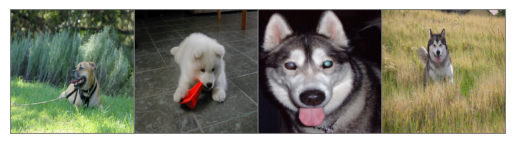

In [ ]:
# Load the entire Stanford Dogs dataset (both train and test splits)
dataset_name = "voxel51/stanford_dogs"
dataset = load_dataset(dataset_name)

# Combine train and test splits into one dataset if needed
train_dataset = dataset['train']

print(f"Total number of images in the Stanford Dogs dataset: {len(train_dataset)}")

# Define image processing parameters
image_size = 256  # Size to resize images
batch_size = 4  # Number of images in each batch

# Define transformations to apply to each image
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize for 3 channels (RGB)
    ]
)

# Transformation function to be applied to each example in the dataset
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# Set transformation on the combined dataset
train_dataset.set_transform(transform)

# Create a DataLoader to load batches of images
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Display a batch of images
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)  # Convert back from normalized
plt.axis('off')
plt.show()


  0%|          | 0/5183 [00:00<?, ?it/s]c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\diffusers\models\attention_processor.py:2383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 5183/5183 [45:10<00:00,  1.91it/s]


Epoch 0 average loss: 0.015426778905941881


100%|██████████| 5183/5183 [45:03<00:00,  1.92it/s]


Epoch 1 average loss: 0.01565098244219551


100%|██████████| 5183/5183 [45:02<00:00,  1.92it/s]


Epoch 2 average loss: 0.015047665107146498


100%|██████████| 5183/5183 [44:53<00:00,  1.92it/s]


Epoch 3 average loss: 0.015359107187366248


100%|██████████| 5183/5183 [44:52<00:00,  1.93it/s]

Epoch 4 average loss: 0.01520744681460911


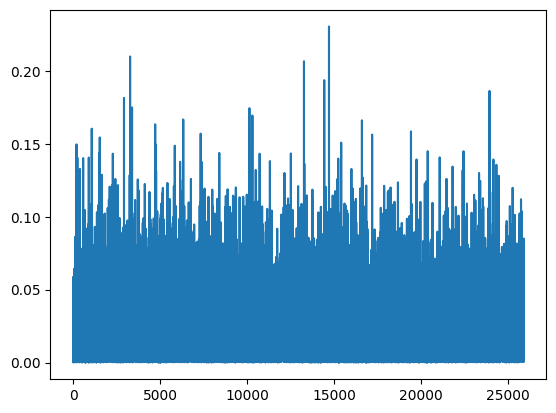

In [5]:
num_epochs = 5  # @param
lr = 5e-7  # 2param
weight_decay = 1e-5
grad_accumulation_steps = 4  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr, weight_decay=weight_decay)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)

## Generate some cat images with our fine-tuned model

1000it [05:53,  2.83it/s]


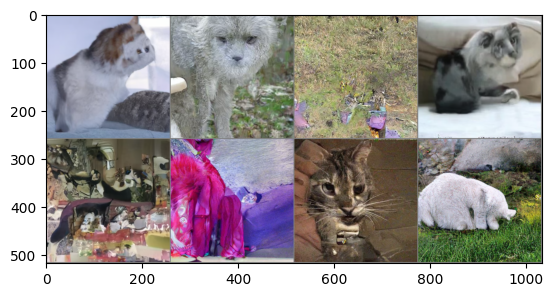

In [8]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

### Save our model

In [7]:
image_pipe.save_pretrained("DogFT_on_Cat_Network.pth")

## Guidance

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-cat-256")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
# scheduler.set_timesteps(num_inference_steps=1000)
image_pipe.scheduler = scheduler
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /Users/wenbo/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/wenbo/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-cat-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [3]:
# def color_loss(images, target_color=(0.1, 0.9, 0.5)):
def color_loss(images, target_color=(0.0, 0.0, 0.0)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = torch.tensor(target_color).to(images.device) * 2 - 1  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

0it [00:00, ?it/s]

0 loss: 38.35748291015625


10it [00:17,  1.64s/it]

10 loss: 26.830230712890625


20it [00:33,  1.64s/it]

20 loss: 18.94029998779297


30it [00:50,  1.63s/it]

30 loss: 13.145998001098633


40it [01:06,  1.64s/it]

40 loss: 8.714689254760742


50it [01:22,  1.63s/it]

50 loss: 5.6429595947265625


60it [01:38,  1.62s/it]

60 loss: 3.6710314750671387


70it [01:55,  1.62s/it]

70 loss: 2.522946357727051


80it [02:11,  1.62s/it]

80 loss: 2.118324041366577


90it [02:27,  1.61s/it]

90 loss: 1.7693357467651367


100it [02:43,  1.63s/it]

100 loss: 1.3835523128509521


110it [03:00,  1.63s/it]

110 loss: 1.2828185558319092


120it [03:16,  1.64s/it]

120 loss: 1.1280014514923096


130it [03:32,  1.64s/it]

130 loss: 1.084949016571045


140it [03:49,  1.63s/it]

140 loss: 1.0578482151031494


150it [04:05,  1.62s/it]

150 loss: 1.0318716764450073


160it [04:21,  1.62s/it]

160 loss: 0.9819893836975098


170it [04:37,  1.62s/it]

170 loss: 0.9510394930839539


180it [04:53,  1.62s/it]

180 loss: 0.937260627746582


190it [05:10,  1.62s/it]

190 loss: 0.9130257368087769


200it [05:26,  1.62s/it]

200 loss: 0.9103929996490479


210it [05:42,  1.62s/it]

210 loss: 0.8948113918304443


220it [05:58,  1.64s/it]

220 loss: 0.8716895580291748


230it [06:15,  1.65s/it]

230 loss: 0.835428774356842


240it [06:31,  1.63s/it]

240 loss: 0.8576306104660034


250it [06:47,  1.63s/it]

250 loss: 0.8498799800872803


260it [07:04,  1.63s/it]

260 loss: 0.8237565755844116


270it [07:20,  1.62s/it]

270 loss: 0.8293609619140625


280it [07:36,  1.62s/it]

280 loss: 0.8049896359443665


290it [07:52,  1.63s/it]

290 loss: 0.8105621337890625


300it [08:09,  1.63s/it]

300 loss: 0.8152375221252441


310it [08:25,  1.63s/it]

310 loss: 0.8139439821243286


320it [08:42,  1.65s/it]

320 loss: 0.8064655065536499


330it [08:58,  1.62s/it]

330 loss: 0.8058607578277588


340it [09:14,  1.63s/it]

340 loss: 0.8119381666183472


350it [09:30,  1.64s/it]

350 loss: 0.8075159788131714


360it [09:47,  1.63s/it]

360 loss: 0.8083875179290771


370it [10:03,  1.63s/it]

370 loss: 0.812122106552124


380it [10:19,  1.62s/it]

380 loss: 0.8143167495727539


390it [10:36,  1.64s/it]

390 loss: 0.8132208585739136


400it [10:52,  1.63s/it]


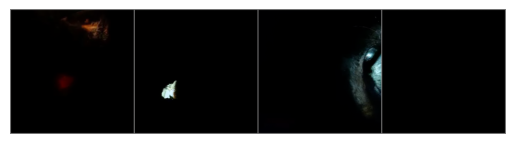

In [ ]:

scheduler.set_timesteps(num_inference_steps=400)
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0, target_color=(0.0, 0.0, 0.0)) * guidance_loss_scale
    if i % 100 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
# Image.fromarray(np.array(im * 255).astype(np.uint8))
plt.imshow(im)
plt.axis('off')  # Remove axis for a cleaner look
plt.show()

In [ ]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(5),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)  # Squared Great Circle Distance
    return dists.mean()

In [ ]:
prompt = "A cat on a table"

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
# Image.fromarray(np.array(im * 255).astype(np.uint8))
plt.imshow(im)
plt.axis('off')  # Remove axis for a cleaner look
plt.show()